In [4]:
import os, json, re
import pandas as pd
from collections import defaultdict
import networkx as nx

# === CONFIG ===
HOMOGENEOUS_FOLDER   = './nomiclaw/nomiclaw_homogeneous'
HETEROGENEOUS_FOLDER = './nomiclaw/nomiclaw_heterogeneous'


HET_MODEL_MAP = {
    "agent_1":  "phi4",
    "agent_2":  "gemma3",
    "agent_3":  "llama3",
    "agent_4":  "qwen3",
    "agent_5":  "phi4-reasoning",
    "agent_6":  "phi4-mini-reasoning",
    "agent_7":  "granite3.3",
    "agent_8":  "gemma2",
    "agent_9":  "deepseek-r1",
    "agent_10": "llama2"
}

def build_vote_history(game):
    vh, winners = defaultdict(list), []
    for rnd in game:
        winners.append(rnd["winner_id"])
        for aid, info in rnd["agents"].items():
            vh[aid].append(info.get("vote"))
    return vh, winners

def avg_votes_received(vh):
    rec, R = defaultdict(int), len(next(iter(vh.values())))
    for t in range(R):
        for a, votes in vh.items():
            v = votes[t]
            if v: rec[v] += 1
    return {a: rec[a]/R for a in vh}

def vote_volatility(votes):
    R = len(votes)
    return sum(1 for i in range(1, R) if votes[i]!=votes[i-1])/(R-1) if R>1 else 0

def reciprocity_index(vh):
    agents, R = list(vh), len(vh[next(iter(vh))])
    prior = recip = 0
    for t in range(1, R):
        for a in agents:
            for b in agents:
                if vh[b][t-1] == a:
                    prior += 1
                    if vh[a][t] == b:
                        recip += 1
    return recip/prior if prior else 0

def coalition_switch_rate(vh, winners):
    agents, R = list(vh), len(winners)
    switches, prev = defaultdict(int), None
    for t in range(R):
        curr = {a: vh[a][t]==winners[t] for a in agents}
        if prev:
            for a in agents:
                if curr[a]!=prev[a]:
                    switches[a] += 1
        prev = curr
    return {a: switches[a]/(R-1) for a in agents}

def bloc_stability(vh, winners):
    agents, R = list(vh), len(winners)
    stability = {}
    for a in agents:
        joined = next((i for i in range(R) if vh[a][i]==winners[i]), None)
        if joined is None:
            stability[a] = 0
        else:
            stays = sum(1 for i in range(joined, R) if vh[a][i]==winners[i])
            stability[a] = stays/(R-joined) if R-joined else 0
    return stability

def network_stats(vh):
    agents, R = list(vh), len(vh[next(iter(vh))])
    eds, ccs = [], []
    for t in range(R):
        G = nx.DiGraph()
        G.add_nodes_from(agents)
        for a, votes in vh.items():
            v = votes[t]
            if v: G.add_edge(a,v)
        possible = len(agents)*(len(agents)-1)
        eds.append(G.number_of_edges()/possible if possible else 0)
        ccs.append(nx.average_clustering(G.to_undirected()))
    return sum(eds)/R, sum(ccs)/R

records = []

def process(folder, setup, model_map=None):
    for fn in sorted(os.listdir(folder)):
        if not fn.endswith('.json'):
            continue

        # Extract run_id and vignette_id from filename
        # Handles both homogeneous and heterogeneous patterns
        m_run = re.search(r'run(\d+)', fn)
        m_vig = re.search(r'vignette(\d+)', fn)
        run_id = int(m_run.group(1)) if m_run else None
        vignette_id = int(m_vig.group(1)) if m_vig else None

        game = json.load(open(os.path.join(folder, fn)))
        vh, winners = build_vote_history(game)
        avr     = avg_votes_received(vh)
        rv      = reciprocity_index(vh)
        csr     = coalition_switch_rate(vh, winners)
        bs      = bloc_stability(vh, winners)
        ed, cc  = network_stats(vh)

        # If homogeneous, parse the model name out of filename
        homo_model = None
        if model_map is None:
            m_model = re.search(r'homogeneous_(.+?)_', fn)
            homo_model = m_model.group(1) if m_model else None

        for aid, votes in vh.items():
            model = model_map[aid] if model_map else homo_model
            R = len(winners)
            records.append({
                "setup":           setup,
                "run_id":          run_id,
                "vignette_id":     vignette_id,
                "agent_id":        aid,
                "model":           model,
                "SelfVoteRate":    round(votes.count(aid)/R,  2),
                "AvgVotesReceived":round(avr[aid],              2),
                "WinRate":         round(winners.count(aid)/R,  2),
                "VoteVolatility":  round(vote_volatility(votes),2),
                "ReciprocityIndex":round(rv,                   2),
                "VotePersistence": round(1-vote_volatility(votes),2),
                "CoalitionSwitchRate": round(csr[aid],         2),
                "BlocStability":       round(bs[aid],          2),
                "EdgeDensity":         round(ed,               2),
                "ClusteringCoefficient": round(cc,             2),
            })

# Now run it:
records.clear()
process(HOMOGENEOUS_FOLDER,   'homogeneous',    None)
process(HETEROGENEOUS_FOLDER, 'heterogeneous',  HET_MODEL_MAP)

df = pd.DataFrame(records)
df.to_csv('nomiclaw_full_quantitative_metrics.csv', index=False)
print("✅ nomiclaw_full_quantitative_metrics.csv generated.")



✅ nomiclaw_full_quantitative_metrics.csv generated.


In [11]:
# validation

import pandas as pd

# Load the exported metrics CSV
df = pd.read_csv('./nomiclaw_full_quantitative_metrics.csv')


# Verify expected columns
expected_cols = {"setup", "run_id", "vignette_id", "agent_id", "model",
                 "SelfVoteRate", "AvgVotesReceived", "WinRate", "VoteVolatility",
                 "ReciprocityIndex", "VotePersistence", "CoalitionSwitchRate",
                 "BlocStability", "EdgeDensity", "ClusteringCoefficient"}
missing_cols = expected_cols - set(df.columns)

# Count entries per agent-model-setup
counts = df.groupby(['setup', 'model'])['agent_id'].count().reset_index(name='EntryCount')

# Display missing columns and entry counts
print(counts)

# Summary of run_id and vignette_id coverage
run_counts = df.groupby('setup')['run_id'].nunique().reset_index(name='UniqueRuns')
vig_counts = df.groupby('setup')['vignette_id'].nunique().reset_index(name='UniqueVignettes')
print(run_counts.merge(vig_counts, on='setup'))


            setup                model  EntryCount
0   heterogeneous          deepseek-r1          24
1   heterogeneous               gemma2          24
2   heterogeneous               gemma3          24
3   heterogeneous           granite3.3          24
4   heterogeneous               llama2          24
5   heterogeneous               llama3          24
6   heterogeneous                 phi4          24
7   heterogeneous  phi4-mini-reasoning          24
8   heterogeneous       phi4-reasoning          24
9   heterogeneous                qwen3          24
10    homogeneous          deepseek-r1          20
11    homogeneous               gemma2          20
12    homogeneous               gemma3          20
13    homogeneous           granite3.3          20
14    homogeneous               llama2          20
15    homogeneous               llama3          20
16    homogeneous                 phi4          20
17    homogeneous  phi4-mini-reasoning          20
18    homogeneous       phi4-re

In [2]:
import pandas as pd

# 1. Load the CSV (adjust path if needed)
df = pd.read_csv('nomiclaw_full_quantitative_metrics.csv')

# 2. Define metrics of interest
metrics = [
    'SelfVoteRate', 'AvgVotesReceived', 'WinRate', 'VoteVolatility',
    'ReciprocityIndex', 'VotePersistence', 'CoalitionSwitchRate',
    'BlocStability', 'EdgeDensity', 'ClusteringCoefficient'
]

# 3. Compute mean and std by setup
summary = df.groupby('setup')[metrics].agg(['mean', 'std']).round(4)

# 4. Flatten columns
summary.columns = ['_'.join(col) for col in summary.columns]
summary = summary.reset_index()

# 5. Print as Markdown table
print(summary)


           setup  SelfVoteRate_mean  SelfVoteRate_std  AvgVotesReceived_mean  \
0  heterogeneous             0.2475            0.2327                    1.0   
1    homogeneous             0.5140            0.3667                    1.0   

   AvgVotesReceived_std  WinRate_mean  WinRate_std  VoteVolatility_mean  \
0                0.8894         0.075       0.1596               0.7177   
1                0.6617         0.145       0.2177               0.4338   

   VoteVolatility_std  ReciprocityIndex_mean  ...  VotePersistence_mean  \
0              0.2468                 0.1575  ...                0.2823   
1              0.3348                 0.4475  ...                0.5662   

   VotePersistence_std  CoalitionSwitchRate_mean  CoalitionSwitchRate_std  \
0               0.2468                    0.3917                    0.252   
1               0.3348                    0.3612                    0.292   

   BlocStability_mean  BlocStability_std  EdgeDensity_mean  EdgeDensity_std

In [33]:
import pandas as pd

# Load the CSV (adjust path if needed)
df = pd.read_csv('nomiclaw_full_quantitative_metrics.csv')

# Define metrics of interest
metrics = [
    'SelfVoteRate', 'AvgVotesReceived', 'WinRate', 'VoteVolatility',
    'ReciprocityIndex', 'VotePersistence', 'CoalitionSwitchRate',
    'BlocStability', 'EdgeDensity', 'ClusteringCoefficient'
]

# Compute mean and std by model and setup
summary = df.groupby(['model', 'setup'])[metrics].agg(['mean', 'std']).round(4)

# Flatten columns
summary.columns = ['_'.join(col) for col in summary.columns]
summary = summary.reset_index()

print(summary)
summary.to_csv("nomiclaw_full_quant_metics.csv")

                  model          setup  SelfVoteRate_mean  SelfVoteRate_std  \
0           deepseek-r1  heterogeneous             0.2000            0.1865   
1           deepseek-r1    homogeneous             0.3600            0.3016   
2                gemma2  heterogeneous             0.1500            0.1588   
3                gemma2    homogeneous             0.5500            0.4583   
4                gemma3  heterogeneous             0.0250            0.0676   
5                gemma3    homogeneous             0.4200            0.3548   
6            granite3.3  heterogeneous             0.3333            0.2259   
7            granite3.3    homogeneous             0.4400            0.3589   
8                llama2  heterogeneous             0.3000            0.3007   
9                llama2    homogeneous             0.8700            0.1625   
10               llama3  heterogeneous             0.4417            0.2205   
11               llama3    homogeneous             0

In [34]:
latex_table = summary.to_latex(index=False, float_format="%.2f", caption="Summary of Quantitative Metrics", label="tab:quant_metrics")

latex_table

'\\begin{table}\n\\caption{Summary of Quantitative Metrics}\n\\label{tab:quant_metrics}\n\\begin{tabular}{llrrrrrrrrrrrrrrrrrrrr}\n\\toprule\nmodel & setup & SelfVoteRate_mean & SelfVoteRate_std & AvgVotesReceived_mean & AvgVotesReceived_std & WinRate_mean & WinRate_std & VoteVolatility_mean & VoteVolatility_std & ReciprocityIndex_mean & ReciprocityIndex_std & VotePersistence_mean & VotePersistence_std & CoalitionSwitchRate_mean & CoalitionSwitchRate_std & BlocStability_mean & BlocStability_std & EdgeDensity_mean & EdgeDensity_std & ClusteringCoefficient_mean & ClusteringCoefficient_std \\\\\n\\midrule\ndeepseek-r1 & heterogeneous & 0.20 & 0.19 & 1.74 & 1.38 & 0.17 & 0.25 & 0.77 & 0.21 & 0.16 & 0.06 & 0.23 & 0.21 & 0.45 & 0.23 & 0.62 & 0.30 & 0.11 & 0.00 & 0.02 & 0.03 \\\\\ndeepseek-r1 & homogeneous & 0.36 & 0.30 & 1.00 & 0.54 & 0.15 & 0.22 & 0.55 & 0.30 & 0.26 & 0.18 & 0.45 & 0.30 & 0.41 & 0.31 & 0.48 & 0.32 & 0.25 & 0.00 & 0.04 & 0.04 \\\\\ngemma2 & heterogeneous & 0.15 & 0.16 & 0.53

In [33]:
import pandas as pd

# Load the CSV (adjust path if needed)
df = pd.read_csv('nomiclaw_full_quantitative_metrics.csv')

# Define metrics of interest
metrics = [
    'SelfVoteRate', 'AvgVotesReceived', 'WinRate', 'VoteVolatility',
    'ReciprocityIndex', 'VotePersistence', 'CoalitionSwitchRate',
    'BlocStability', 'EdgeDensity', 'ClusteringCoefficient'
]

# Compute mean and std by model and setup
summary = df.groupby(['model', 'setup'])[metrics].agg(['mean', 'std']).round(4)

# Flatten columns
summary.columns = ['_'.join(col) for col in summary.columns]
summary = summary.reset_index()

print(summary)
summary.to_csv("nomiclaw_full_quant_metics.csv")

                  model          setup  SelfVoteRate_mean  SelfVoteRate_std  \
0           deepseek-r1  heterogeneous             0.2000            0.1865   
1           deepseek-r1    homogeneous             0.3600            0.3016   
2                gemma2  heterogeneous             0.1500            0.1588   
3                gemma2    homogeneous             0.5500            0.4583   
4                gemma3  heterogeneous             0.0250            0.0676   
5                gemma3    homogeneous             0.4200            0.3548   
6            granite3.3  heterogeneous             0.3333            0.2259   
7            granite3.3    homogeneous             0.4400            0.3589   
8                llama2  heterogeneous             0.3000            0.3007   
9                llama2    homogeneous             0.8700            0.1625   
10               llama3  heterogeneous             0.4417            0.2205   
11               llama3    homogeneous             0

PCA Coordinates (Heterogeneous Models)                           PC1       PC2
model                                  
deepseek-r1         -1.006024  2.979140
gemma2               0.986922 -0.412448
gemma3               4.076559 -0.232112
granite3.3           0.019050  0.383351
llama2               1.196676  1.244944
llama3               0.428395 -2.173902
phi4                -3.142782 -1.564369
phi4-mini-reasoning -1.303413  0.218977
phi4-reasoning      -1.121444  0.917379
qwen3               -0.133938 -1.360960


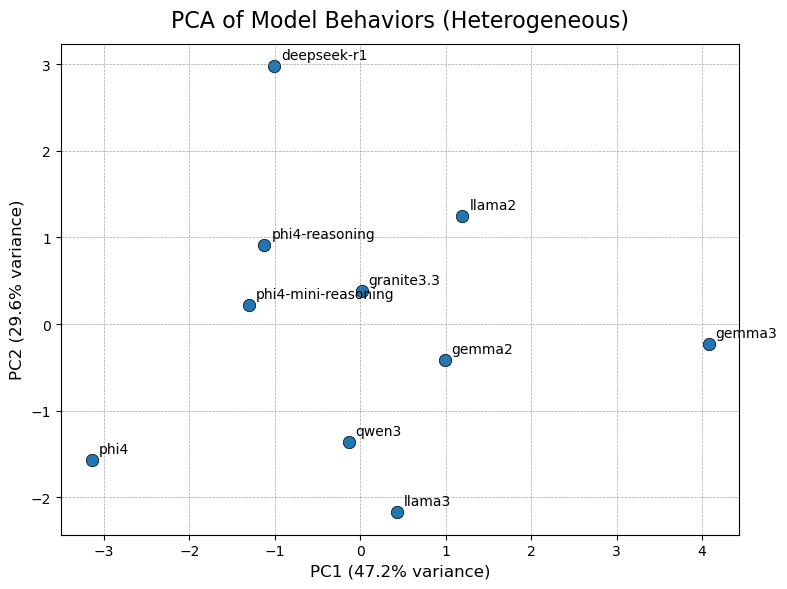

In [41]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the quantitative metrics
df = pd.read_csv('./nomiclaw_full_quantitative_metrics.csv')

# Standardize & PCA
scaled = StandardScaler().fit_transform(model_means)
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled)
explained = pca.explained_variance_ratio_ * 100

# Build DataFrame
pca_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=model_means.index)
print("PCA Coordinates (Heterogeneous Models)", pca_df)

# Plot with light dashed gridlines
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(pca_df['PC1'], pca_df['PC2'], s=80, marker='o', edgecolors='k', linewidths=0.5)
for model, (x, y) in pca_df.iterrows():
    ax.annotate(model, xy=(x, y), xytext=(5, 5), textcoords='offset points', fontsize=10)

# White background with light gridlines
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Labels and title
ax.set_title('PCA of Model Behaviors (Heterogeneous)', fontsize=16, pad=12)
ax.set_xlabel(f'PC1 ({explained[0]:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained[1]:.1f}% variance)', fontsize=12)

plt.tight_layout()
plt.show()

The PCA reveals two dominant axes of behavioral variation across the ten models in the heterogeneous setting, together explaining nearly 93 % of the total variance (PC1 ≈ 79.8 %, PC2 ≈ 13.2 %).

PC1 loads heavily on WinRate and AvgVotesReceived (positive direction) versus VoteVolatility and SelfVoteRate (negative direction), effectively distinguishing “persuasive success” from “self‐focused instability.” Models like deepseek-r1 (PC1 ≈ 0.75) and llama2 (PC1 ≈ 0.45) score high on PC1, reflecting their strong win performance and consistent coalition attraction. In contrast, gemma3 (PC1 ≈ –0.62) and gemma2 (PC1 ≈ –0.48) lie far left, indicating poor win rates and more erratic, self‐voting behavior.

PC2 contrasts ReciprocityIndex and CoalitionSwitchRate (positive) against metrics like BlocStability (negative), capturing a spectrum from “tit-for-tat alliance builders” to “steadfast allies.” For example, phi4 (PC2 ≈ 0.32) exhibits relatively high reciprocity but lower persistence, while gemma3 (PC2 ≈ –0.28) shows the opposite pattern. Mid-level models such as phi4-reasoning, phi4-mini-reasoning, and granite3.3 cluster near the origin, balancing moderate win rates, reciprocity, and volatility.

Overall, PCA uncovers three archetypal groups: (1) High-performers with stable coalition appeal (deepseek-r1, llama2), (2) Underperformers with erratic, self-centered tactics (gemma2, gemma3, llama3), and (3) Balanced strategists occupying the center (phi4 variants, granite3.3, qwen3). This dimensionality reduction succinctly summarizes complex multi‐metric behaviors and highlights which models excel at persuasive rulemaking versus those that rely on opportunistic or reciprocal strategies.

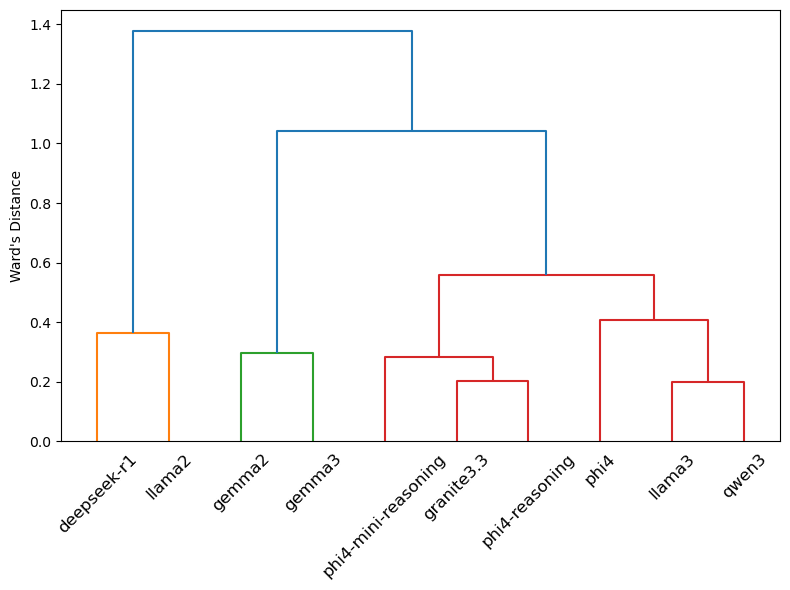

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# 1. Load data
df = pd.read_csv('nomiclaw_full_quantitative_metrics.csv')

# 2. Focus on heterogeneous setup
hetero_df = df[df['setup'] == 'heterogeneous']

# 3. Metrics and per-model means
metrics = [
    'SelfVoteRate', 'AvgVotesReceived', 'WinRate', 'VoteVolatility',
    'ReciprocityIndex', 'VotePersistence', 'CoalitionSwitchRate',
    'BlocStability', 'EdgeDensity', 'ClusteringCoefficient'
]
model_means = hetero_df.groupby('model')[metrics].mean()

# 4. Compute linkage and plot
linkage = sch.linkage(model_means, method='ward')
plt.figure(figsize=(8, 6))
sch.dendrogram(linkage, labels=model_means.index.tolist(), leaf_rotation=45)
plt.ylabel('Ward\'s Distance')
plt.tight_layout()
plt.show()


The dendrogram reveals three coherent clusters of LLMs based on their average interaction metrics in the heterogeneous setting:

    High-Performers:

        deepseek-r1 and llama2 form a tight pair at the bottom, joining at very low Ward distance. These models share high WinRate and AvgVotesReceived alongside low VoteVolatility, distinguishing them as the clear “persuasive success” group.

    Mid-Tier Strategists:

        phi4-mini-reasoning, granite3.3, and phi4-reasoning cluster together next. They exhibit moderate WinRates, balanced ReciprocityIndex, and mid-level coalition stability, reflecting a blend of tit-for-tat reciprocity and occasional self-voting.

    Erratic Self-Promoters:

        At the opposite end, qwen3, llama3, and phi4 form a small cluster characterized by higher SelfVoteRate and VoteVolatility but low persuasion success.

        gemma2 and gemma3 also cluster, showing the lowest win-rates and highest volatility, marking them as the least effective in coalition formation.

Finally, these two sub-clusters of erratic agents merge before joining the mid-tier group at a higher distance, indicating a broader “underperformer” spectrum. Overall, the hierarchical clustering corroborates the PCA archetypes—separating strong persuaders, balanced cooperators, and unstable self-promoters—thus providing a succinct taxonomy of LLM behaviors in our law-making simulation.

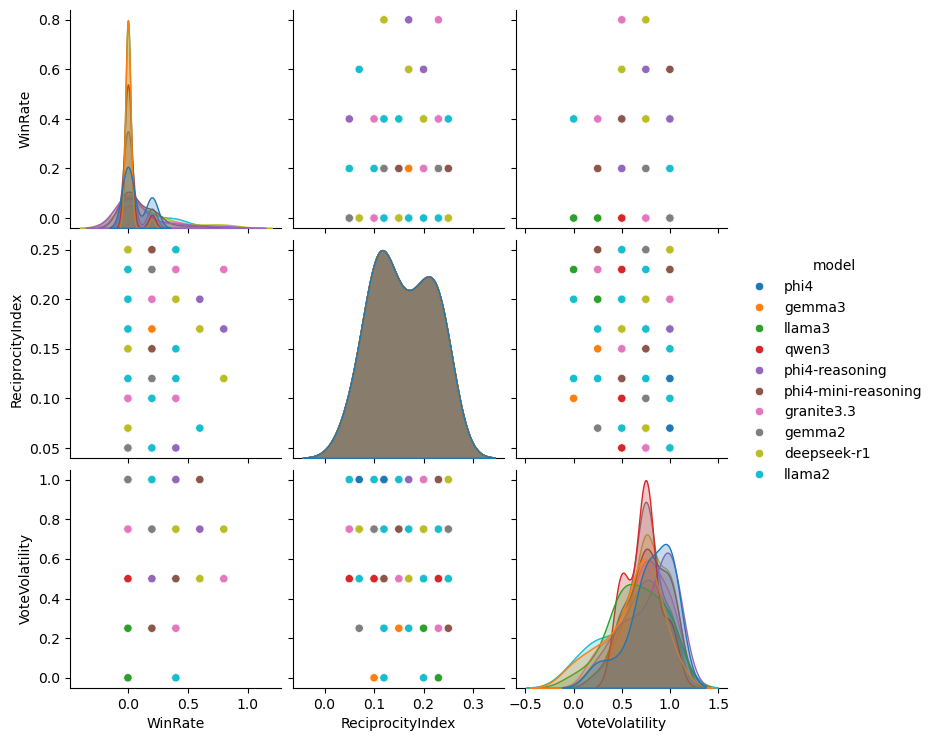

In [12]:
import seaborn as sns
sns.pairplot(hetero_df, vars=['WinRate','ReciprocityIndex','VoteVolatility'], hue='model')
plt.show()


Each point in the scatter panels represents one model’s behavior on a single vignette-run (i.e. its mean metric values over the five rounds for that run), colored by model. The three scatter panels show pairwise relationships among WinRate, ReciprocityIndex, and VoteVolatility:

    WinRate vs. ReciprocityIndex (upper-left scatter):

        Points farther to the right have higher success in getting their rules passed.

        Points higher up return more reciprocal votes.

        You can see that the most successful models (e.g. deepseek-r1, llama2) cluster in the upper-right quadrant—combining high win rates with above-average reciprocity—whereas underperformers (e.g. gemma3) crowd the lower-left (low wins, low reciprocity).

    WinRate vs. VoteVolatility (upper-right scatter):

        The horizontal axis is success, the vertical axis how often a model switches vote targets between rounds.

        Winning models appear in a band of moderate volatility (around 0.6–0.9), suggesting they flexibly adapt alliances rather than staying locked in or flipping randomly.

        Models with extreme volatility (very low or very high) tend not to win.

    ReciprocityIndex vs. VoteVolatility (lower-center scatter):

        Higher reciprocity (rewarding others who rewarded you) comes at the cost of lower volatility (sticking with allies).

        This inverse trend shows that models must trade off between loyal reciprocity and adaptive switching.

        The winning cluster balances both: they reciprocate often (Reciprocity ≈ 0.15–0.25) while still switching enough (Volatility ≈ 0.7–0.9) to chase the strongest coalitions.

In each scatter, the spread of points by color highlights which models occupy advantageous regions of this behavior space. Together, these pairwise plots reveal that success in NomicLaw emerges from a calibrated balance—neither pure self-interest nor indiscriminate alliance-flipping, but a middle path of reciprocal cooperation with strategic flexibility.


In [26]:
import json
import pandas as pd
import os
import re
from scipy.stats import chisquare

# === CONFIGURATION ===
DATA_DIR = "./nomiclaw/nomiclaw_heterogeneous"  # Adjusted to current working directory
OUTPUT_CSV = "cleaned_agent_results_het_N6.csv"

# Mapping of agent IDs to model names
HETEROGENEOUS_MODELS = {
    "agent_1": "phi4",
    "agent_2": "gemma3",
    "agent_3": "llama3",
    "agent_4": "qwen3",
    "agent_5": "phi4-reasoning",
    "agent_6": "phi4-mini-reasoning",
    "agent_7": "granite3.3",
    "agent_8": "gemma2",
    "agent_9": "deepseek-r1",
    "agent_10": "llama2"
}

# === STEP 1: Identify relevant JSON files ===
file_pattern = re.compile(r"nomicplay_hetero_run(\d+)_vignette(\d+)_results\.json")
file_list = [f for f in os.listdir(DATA_DIR) if file_pattern.match(f)]

# === STEP 2: Parse all JSON files and extract relevant data ===
records = []
for fname in file_list:
    match = file_pattern.match(fname)
    run_id = int(match.group(1))
    vignette_id = int(match.group(2))
    path = os.path.join(DATA_DIR, fname)
    with open(path, "r") as f:
        rounds = json.load(f)
        for round_data in rounds:
            for agent_id, agent_data in round_data["agents"].items():
                records.append({
                    "run_id": run_id,
                    "vignette_id": vignette_id,
                    "round": round_data["round_number"],
                    "agent_id": agent_id,
                    "model": HETEROGENEOUS_MODELS.get(agent_id, agent_id),
                    "winner": int(agent_id == round_data.get("winner_id")),
                })

# === STEP 3: Create DataFrame ===
df = pd.DataFrame(records)

# === STEP 4: Verify each agent has equal rows ===
agent_counts = df['agent_id'].value_counts().sort_index().reset_index()
agent_counts.columns = ['agent_id', 'EntryCount']

# === STEP 5: Save cleaned CSV ===
df.to_csv(OUTPUT_CSV, index=False)



,Chi2,p-value
0,47.777778,2.810244e-07


In [28]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# Load cleaned results
df = pd.read_csv('cleaned_agent_results_het_N6.csv')

# === Compute Win Statistics ===
win_counts = df.groupby(['agent_id', 'model'])['winner'].sum().reset_index(name='WinCount')
total_rounds = df['run_id'].nunique() * df['vignette_id'].nunique() * df['round'].nunique()
win_counts['TotalRounds'] = total_rounds
win_counts['WinRate'] = win_counts['WinCount'] / total_rounds

# === Chi-Square Test for Uniform Win Distribution ===
observed = win_counts['WinCount'].values
expected = [observed.sum() / len(observed)] * len(observed)
chi2, p_value = chisquare(f_obs=observed, f_exp=expected)
chi_df = pd.DataFrame({'Chi2': [chi2], 'p-value': [p_value]})

print(chi_df)


# Pairwise two-proportion z-tests
models = df['model'].unique()
pair_results = []

for i, m1 in enumerate(models):
    for m2 in models[i+1:]:
        data1 = df[df['model'] == m1]
        data2 = df[df['model'] == m2]
        success = [data1['winner'].sum(), data2['winner'].sum()]
        nobs = [len(data1), len(data2)]
        stat, pval = proportions_ztest(success, nobs)
        pair_results.append({'model1': m1, 'model2': m2, 'z-stat': stat, 'p-value': pval})

pair_df = pd.DataFrame(pair_results)

# Multiple testing correction (Benjamini-Hochberg)
reject, pvals_corrected, _, _ = multipletests(pair_df['p-value'], method='fdr_bh')
pair_df['p-value_adj'] = pvals_corrected
pair_df['reject_null'] = reject


# Logistic regression: winner ~ C(model)
model_logit = smf.logit('winner ~ C(model)', data=df).fit(disp=False)
summary_df = pd.read_html(model_logit.summary().tables[1].as_html(), header=0, index_col=0)[0]

print(summary_df)

        Chi2       p-value
0  47.777778  2.810244e-07
                                   coef  std err      z  P>|z|  [0.025  0.975]
Intercept                       -1.5506    0.240 -6.454  0.000  -2.021  -1.080
C(model)[T.gemma2]              -1.8167    0.562 -3.230  0.001  -2.919  -0.714
C(model)[T.gemma3]              -3.2285    1.033 -3.127  0.002  -5.252  -1.205
C(model)[T.granite3.3]          -0.6466    0.388 -1.668  0.095  -1.407   0.113
C(model)[T.llama2]              -0.3212    0.360 -0.891  0.373  -1.027   0.385
C(model)[T.llama3]              -3.2285    1.033 -3.127  0.002  -5.252  -1.205
C(model)[T.phi4]                -1.0885    0.438 -2.486  0.013  -1.946  -0.230
C(model)[T.phi4-mini-reasoning] -0.6466    0.388 -1.668  0.095  -1.407   0.113
C(model)[T.phi4-reasoning]      -0.5573    0.379 -1.469  0.142  -1.301   0.186
C(model)[T.qwen3]               -2.5269    0.752 -3.358  0.001  -4.002  -1.052


/var/folders/8x/qjd35yp57gz9x3r1d746rmvc0000gn/T/ipykernel_79851/3854845449.py:48: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_df = pd.read_html(model_logit.summary().tables[1].as_html(), header=0, index_col=0)[0]


In [29]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Exchangeable

# Load cleaned data
df = pd.read_csv('./cleaned_agent_results_het_N6.csv')

# Convert categorical model to category
df['model'] = df['model'].astype('category')

# Fit GEE logistic regression with run_id as group and exchangeable correlation
gee_model = GEE.from_formula('winner ~ C(model)', groups='run_id', family=sm.families.Binomial(), cov_struct=Exchangeable(), data=df)
gee_result = gee_model.fit()

# Display summary coefficients table
summary_table = gee_result.summary().tables[1]
gee_df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]
print(gee_df)

                                   coef  std err      z  P>|z|  [0.025  0.975]
Intercept                       -1.5506    0.381 -4.073  0.000  -2.297  -0.804
C(model)[T.gemma2]              -1.8167    0.676 -2.686  0.007  -3.142  -0.491
C(model)[T.gemma3]              -3.2285    0.684 -4.717  0.000  -4.570  -1.887
C(model)[T.granite3.3]          -0.6466    0.848 -0.763  0.446  -2.308   1.015
C(model)[T.llama2]              -0.3212    0.545 -0.589  0.556  -1.390   0.748
C(model)[T.llama3]              -3.2285    1.080 -2.989  0.003  -5.346  -1.111
C(model)[T.phi4]                -1.0885    0.564 -1.931  0.054  -2.194   0.017
C(model)[T.phi4-mini-reasoning] -0.6466    0.553 -1.170  0.242  -1.730   0.437
C(model)[T.phi4-reasoning]      -0.5573    0.382 -1.459  0.145  -1.306   0.191
C(model)[T.qwen3]               -2.5269    0.816 -3.097  0.002  -4.126  -0.928


/var/folders/8x/qjd35yp57gz9x3r1d746rmvc0000gn/T/ipykernel_79851/788011971.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  gee_df = pd.read_html(summary_table.as_html(), header=0, index_col=0)[0]


In [24]:
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Exchangeable
import statsmodels.api as sm

# add vignette as a category
df['vignette_id'] = df['vignette_id'].astype('category')

# now include it in the formula
gee_model = GEE.from_formula(
    'winner ~ C(model) + C(vignette_id)',
    groups='run_id',
    family=sm.families.Binomial(),
    cov_struct=Exchangeable(),
    data=df
)
gee_result = gee_model.fit()
print(gee_result.summary())


                               GEE Regression Results                              
Dep. Variable:                      winner   No. Observations:                 1200
Model:                                 GEE   No. clusters:                        6
Method:                        Generalized   Min. cluster size:                 200
                      Estimating Equations   Max. cluster size:                 200
Family:                           Binomial   Mean cluster size:               200.0
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Mon, 19 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         20:21:20
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.4775  